# Some Theoretical Background

The Ising Model Hamiltonian:

$$ H = -J \sum^{N^2} \sum S_a\cdot S_b - B\sum^{N^2}S_a $$

where $J$ is the spin-spin interaction constant and $B$ the magnetic field.

The probability of a particular collenction of spins is given by the Boltzman factor:

$$ p(S) = \frac{1}{Z}e^{-βH(S)} $$

with $β = \frac{1}{k_BT}$ and $Z$ the partition function.

The Energy of the lattice if given by:

$$ E = -J \sum \sum S_aS_b - B\sum S_a $$

and the magnetic moment:

$$ m = \sum S_a $$


The algorithm we are going to use is called Metropolis-Hastincs Monte Carlo and it goes like this:

    1. Initialize an NxN grid of spins {-1,1}
    2. Flip a spin on the lattice at random
    3. Compute the ratio:
        
$$ r = \frac{p(S_{fliped})}{p(S)} = e^{-β(H(S_flipped)-H(S)}$$

    4. Massaging a little bit the expression:
        
$$ H(S_{flipped})-H(S)$$

    and defining the local field around the flipped spin as:
           
$$ f = S_{flipped}(i+1,j) + S_{flipped}(i-1,j) + S_{flipped}(i,j+1) + S_{flipped}(i,j-1)$$

    we get that the ratio can be expressed only with the flipped spin:
           
$$ r = e^{-2βS_flipped(Jf+B)})$$
       
    5. If the ratio is larger than 1 ( r>1 ) it means that the probability of a lattice with the spin flip is bigger than without, thus we accept the change.
        
    6. If the ratio less than 1 we do not yet reject the spin flip, but drawn from a uniform distribution a number h, between 0 and 1.
        
    7. If r > h we then accept the change. If r < h we finally reject the change and keep the lattice as before.
        
    8. Repeat from 2.

The goal is: Starting from a random configuration of Spins to find a specific configuration that is stable, ergo in equilibrium, ergo doesn't change with time. This can be an intractable task for large grids, fluctuating magnetic fields, different temperatures and many times we could be stuck in a local minima.


## The Idea
Initialy I was so happy to have a low level API (dask.array) that ressembles so much a grid (2D array). "Great", I said, just chop it up in pieces, apply the algorithm, you're done. But the more I thought about it the more it realised that I did not understand the implications of changing local fields indipendently, and then calculating the whole energy of the grid, maybe there are none. But the more I thought about boundary conditions the less excited I become. So in order not to code a physics mess, I scratched the idea. But the next day I had another idea:

What if, instead of messing with local spin fields, I repeat the same grid into "fake universies" (aka 3rd axis of the dask.array) in which the spin grid evolves indipendently and everyonce in a while we check the total energy of the grids and pick the grid with the lowest one. Delete all the others and then replicate the one we picked and start the process again. After a while, check the energies again, pick the grid with the lowest, etc. This may sound very simple, but eventually lets you explore more possible "random walks" of the spins and pick and choose the best. (Sounds a little bit like quantum)

This idea could have many variations in special conditions, eg. What happens if two energies are close enough? Maybe we should keep both grids, evolve them and see what happens. Or maybe we don't start with the same randomness. Or maybe the grids somehow are connected with each other (paraller tempering). Or maybe we flip different amount of spins on different spins. Or maybe everything above.

Anyway in this notebook I'm gonna do the simplest thing possible: Just prepare them, let them evolve, after a bunch of iterations pick the best, replicate it, repeat experiment. Hopefully, after a number of spins, this scales better than -more than one- spin flips, or just -brute force cpu speed-.

In [1]:
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
import time
from datetime import timedelta

In [2]:
from dask.distributed import Client
#client = Client("10.0.0.4:8786")
client = Client()
client

Client Scheduler: tcp://127.0.0.1:62982 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 16.99 GB


# Defining some lattice constants

In [3]:
# Lattice length. Essentialy gives me the number of particles = N^2
N = 1024
#Spin coupling constant
J = 4
#Self interaction with external magnetic field
B = 1
#Unitless k_B
k_B = 1
#Universes
rep = 10
#we'll need those for demostration purposes
i,j = np.random.choice(N,rep) ,np.random.choice(N,rep)

In [4]:
grid = da.random.choice((-1,1),(N,N))
grid = da.repeat(grid[np.newaxis,:,:],repeats=rep,axis=0)
grid = grid.rechunk((1,N,N))
grid

dask.array<rechunk-merge, shape=(10, 1024, 1024), dtype=int32, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>

In [11]:
del grid

To calculate the energy of the grid I need to sum the spins of the 4 neighbouring elements of the central spin. I will use the same trick as the 1D chain, by moving all elements of the Array one position "down" and summing with an array that has moved all the elements "up" and summing with an array that moved all the elements right and same for left, I end up with an array that contains the sums of all the 4 neighbours of every spin.

In [5]:
def lattice_Energy(grid):
    #Calculating a matrix with the local field of each spin
    s_up , s_dwn  = np.roll(grid,-1,axis=1) , np.roll(grid,1,axis=1)
    s_lft , s_right = np.roll(grid,-1,axis=2) , np.roll(grid,1,axis=2)
    local_fields = s_up + s_dwn + s_lft + s_right
    return ((-J)*grid*local_fields -B*grid).rechunk((1,N,N))

In [6]:
def magnetic_moment(grid):
    return np.sum(grid,axis=(1,2))

In [7]:
def compute_ratio(grid,i,j):    
    # Select the spins to flip
    spins = []
    for k in range(rep):
        spins = np.append(spins, grid[k,i[k],j[k]])

    # Creating periodic boundary conditions just in case we flip a spin on the boundaries
    grid = da.overlap.overlap(grid, depth={1: 1, 2: 1},boundary={1: 'periodic', 2: 'periodic'})#.compute()
    
    # Calculate f. f is just an intermediate function that calculates the local change in energy due to the spin flip
    f = []
    for k in range(rep):
        f = np.append( f , (grid[k,i[k]+1,j[k]] + grid[k,i[k]-1,j[k]] + grid[k,i[k],j[k]+1] + grid[k,i[k],j[k]-1]) )
    
    # Finaly calculate the ratio of the change in energies due to the spin flip
    return np.exp ( (-2)*(1/(k_B*Temperature))*spins*(J*f + B) )#.compute()

In [8]:
compute_ratio(grid,i,j).visualize()

NameError: name 'Temperature' is not defined

In [9]:
def spin_move(grid,ratio,i,j):
    
    # UNFORTUNATELY DIRECT assignment was implemented in DASK version 2021.04.1, like literally a month after....
    grid = np.array(grid)
    
    h = np.random.uniform(low=0.0, high=1.0, size=rep)

    for k in range(rep):
        if ratio[k] > 1:
            grid[k,i[k],j[k]] = (-1)*grid[k,i[k],j[k]]
        else:
            if ratio[k] > h[k]:
                grid[k,i[k],j[k]] = (-1)*grid[k,i[k],j[k]]
                
    grid = da.from_array(grid,(1,N,N))
    
    return grid

## We are ready to perform simple calculations
With a number of spin systems that run in parallel. We do not intervene on their state, we are just gathering information about their Energy and magnetization.

In [10]:
Temperature = 250
num_epochs = 100
clock = 0
Energy, Magn = [], []

for epoch in range(num_epochs):
    
    start_time = time.monotonic()
    # Get random indexes
    i,j = np.random.choice(N,rep) ,np.random.choice(N,rep)

    #Compute ratios, it is actually useful to implement this step in a function
    #to handle boundary conditions.
    ratios = compute_ratio(grid,i,j).persist()

    #Apply the Metropolis–Hastings algorithm and return the grid
    grid = spin_move(grid,ratios,i,j).persist()
        
    #Calulation of Statistical Quantities
    #Energy
    Energy.append( np.sum(lattice_Energy(grid),axis=(1,2)).compute() )
    
    #Magnetic Moment
    Magn.append( np.sum(grid,axis=(1,2)).compute() )
    
    #Some time keeping happening here
    end_time = time.monotonic()
    clock += end_time-start_time
    print("Iteration",epoch+1," | System Clock",round(clock,3),"s")

Iteration 1  | System Clock 1.516 s
Iteration 2  | System Clock 2.687 s
Iteration 3  | System Clock 3.906 s
Iteration 4  | System Clock 5.031 s
Iteration 5  | System Clock 6.156 s
Iteration 6  | System Clock 7.312 s
Iteration 7  | System Clock 8.468 s
Iteration 8  | System Clock 9.562 s
Iteration 9  | System Clock 10.796 s
Iteration 10  | System Clock 11.968 s
Iteration 11  | System Clock 13.14 s
Iteration 12  | System Clock 14.312 s
Iteration 13  | System Clock 15.64 s
Iteration 14  | System Clock 16.906 s
Iteration 15  | System Clock 18.0 s
Iteration 16  | System Clock 19.171 s
Iteration 17  | System Clock 20.437 s
Iteration 18  | System Clock 21.687 s
Iteration 19  | System Clock 22.968 s
Iteration 20  | System Clock 24.093 s
Iteration 21  | System Clock 25.296 s
Iteration 22  | System Clock 26.421 s
Iteration 23  | System Clock 27.609 s
Iteration 24  | System Clock 28.734 s
Iteration 25  | System Clock 29.984 s
Iteration 26  | System Clock 31.093 s
Iteration 27  | System Clock 32.2

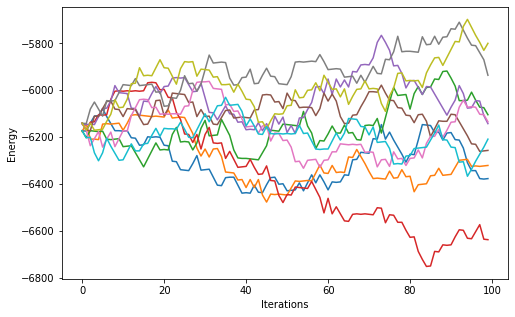

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(Energy)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
plt.show()

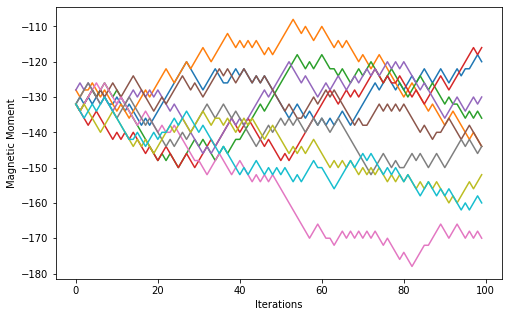

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(Magn)
ax.set_xlabel('Iterations')
ax.set_ylabel('Magnetic Moment')
plt.show()

## I want to search the parameter space of scaling the grid and the chunks with respect to mean Computation Time (for an epoch) / chunk

In [8]:
#Spin coupling constant
J = 4
#Self interaction with external magnetic field
B = 1
#Unitless k_B
k_B = 1

n_chunks = [3,4,8,9,12]
n_grid = [8,16,64,216,512,1024]
results = []

Temperature = 170
num_epochs = 5

clock = 0
c = 0
tot = len(n_chunks)*len(n_grid)

for N in n_grid:
    for rep in n_chunks:
        
        grid = da.random.choice((-1,1),(N,N))
        grid = da.repeat(grid[np.newaxis,:,:],repeats=rep,axis=0)
        grid = grid.rechunk((1,N,N))
        
        start_time = time.monotonic()
        Energy, Magn = [], []
        
        for epoch in range(num_epochs):

            # Get random indexes
            i,j = np.random.choice(N,rep) ,np.random.choice(N,rep)

            #Compute ratios, it is actually useful to implement this step in a function
            #to handle boundary conditions.
            ratios = compute_ratio(grid,i,j).persist()

            #Apply the Metropolis–Hastings algorithm and return the grid
            grid = spin_move(grid,ratios,i,j).persist()

            #Calulation of Statistical Quantities
            #Energy
            Energy.append( np.sum(lattice_Energy(grid),axis=(1,2)).compute() )

            #Magnetic Moment
            Magn.append( np.sum(grid,axis=(1,2)).compute() )

        #Some time keeping happening here    
        end_time = time.monotonic()
        clock = end_time-start_time
        c += 1
        print("Iteration",c,"/",tot," | Iteration Time",round(clock,3),"s")
        
        results.append([N,rep,clock/(num_epochs)])

Iteration 1 / 30  | Iteration Time 9.312 s
Iteration 2 / 30  | Iteration Time 11.695 s
Iteration 3 / 30  | Iteration Time 20.898 s
Iteration 4 / 30  | Iteration Time 22.035 s
Iteration 5 / 30  | Iteration Time 28.812 s
Iteration 6 / 30  | Iteration Time 9.932 s
Iteration 7 / 30  | Iteration Time 11.023 s
Iteration 8 / 30  | Iteration Time 21.041 s
Iteration 9 / 30  | Iteration Time 21.289 s
Iteration 10 / 30  | Iteration Time 27.785 s
Iteration 11 / 30  | Iteration Time 9.1 s
Iteration 12 / 30  | Iteration Time 11.333 s
Iteration 13 / 30  | Iteration Time 18.895 s
Iteration 14 / 30  | Iteration Time 21.889 s
Iteration 15 / 30  | Iteration Time 28.041 s
Iteration 16 / 30  | Iteration Time 9.174 s
Iteration 17 / 30  | Iteration Time 11.811 s
Iteration 18 / 30  | Iteration Time 20.018 s
Iteration 19 / 30  | Iteration Time 21.915 s
Iteration 20 / 30  | Iteration Time 28.539 s
Iteration 21 / 30  | Iteration Time 9.604 s
Iteration 22 / 30  | Iteration Time 11.899 s
Iteration 23 / 30  | Itera

In [30]:
results = np.array(results)
results

array([[   8.        ,    3.        ,    1.86241426],
       [   8.        ,    4.        ,    2.33903298],
       [   8.        ,    8.        ,    4.17954337],
       [   8.        ,    9.        ,    4.40690268],
       [   8.        ,   12.        ,    5.76245666],
       [  16.        ,    3.        ,    1.98632118],
       [  16.        ,    4.        ,    2.20468599],
       [  16.        ,    8.        ,    4.20817693],
       [  16.        ,    9.        ,    4.25782304],
       [  16.        ,   12.        ,    5.55696271],
       [  64.        ,    3.        ,    1.81997867],
       [  64.        ,    4.        ,    2.26655206],
       [  64.        ,    8.        ,    3.77897704],
       [  64.        ,    9.        ,    4.37772663],
       [  64.        ,   12.        ,    5.60821002],
       [ 216.        ,    3.        ,    1.83481798],
       [ 216.        ,    4.        ,    2.36226166],
       [ 216.        ,    8.        ,    4.00363059],
       [ 216.        ,    9.

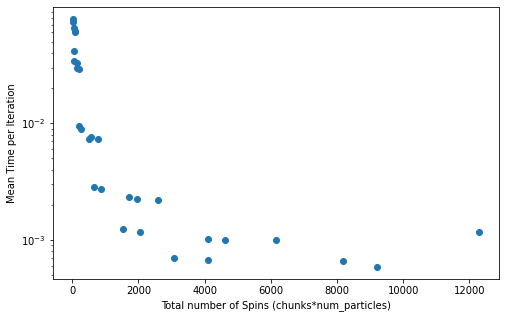

In [38]:
total_spins = results[:,0]*results[:,1]
time_per_spin = results[:,2]/total_spins

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(total_spins,time_per_spin)
ax.set_xlabel('Total number of Spins (chunks*num_particles)')
ax.set_ylabel('Mean Time per Iteration')
plt.yscale('log')
plt.show()

## Speeding up Convergence
In this example we are doing a spin flip in every spin system, read its energy, and choose the lowest. This is supposed to speed up convergence to the global minimum.

In [36]:
# Lattice length. Essentialy gives me the number of particles = N^2
N = 20
#Spin coupling constant
J = 3
#Self interaction with external magnetic field
B = 0
#Unitless k_B
k_B = 1
#Universes
rep = 10

chunk = (1,N,N)

grid = da.random.choice((-1,1),(N,N))
grid = da.repeat(grid[np.newaxis,:,:],repeats=rep,axis=0)
grid = grid.rechunk((1,N,N))
grid

dask.array<rechunk-merge, shape=(10, 20, 20), dtype=int32, chunksize=(1, 20, 20), chunktype=numpy.ndarray>

In [37]:
def choose_reality(grid,Energy):
    reality = np.argmin(Energy)
    new_reality = grid[reality,:,:]
    return new_reality, Energy[reality]

In [38]:
#Time keeping happening here
clock = 0

#Define in which temperature the system lives
Temperature = 270
#Define number of iterations
num_epochs = 600

Energy , mean_Energy_sqrd, mean_Energy = [] , [], []
Magn, Magn_sqrd = [], []

for epoch in range(num_epochs):
    start_time = time.monotonic()
    # Get random indexes
    i,j = np.random.choice(N,rep) ,np.random.choice(N,rep)

    #Compute ratios, it is actually useful to implement this step in a function
    #to handle boundary conditions.
    ratios = compute_ratio(grid,i,j).persist()

    #Apply the Metropolis–Hastings algorithm and return the grid
    grid = spin_move(grid,ratios,i,j).persist()
        
    #keep the last energy of all grids
    energy_of_lattices = np.sum(lattice_Energy(grid),axis=(1,2)).compute()
    
    grid, E = choose_reality(grid,energy_of_lattices)

    #Calulation of Statistical Quantities
    #Energy
    Energy = np.append(Energy,E)
    mean_Energy = np.append(mean_Energy,np.mean(Energy))
    mean_Energy_sqrd = np.append(mean_Energy_sqrd,np.mean(Energy**2))
    
    #Magnetic Moment
    Magn.append( np.sum(grid).compute() )
    Magn_sqrd.append( np.sum(grid**2).compute() )
    
    grid = da.repeat(grid[np.newaxis,:,:],repeats=rep,axis=0)
    grid = grid.rechunk((1,N,N))

    #Some time keeping happening here
    end_time = time.monotonic()
    clock += end_time-start_time
        
    print("Iteration",epoch+1," | System Clock",round(clock,3),"s")
    
    #Early stop
    if epoch>1:
        if mean_Energy[-1] > mean_Energy[-2]:
            c += 1
            if c>3:
                break

Iteration 1  | System Clock 1.046 s
Iteration 2  | System Clock 2.171 s
Iteration 3  | System Clock 3.125 s
Iteration 4  | System Clock 4.187 s
Iteration 5  | System Clock 5.234 s
Iteration 6  | System Clock 6.14 s
Iteration 7  | System Clock 7.265 s
Iteration 8  | System Clock 8.265 s
Iteration 9  | System Clock 9.203 s
Iteration 10  | System Clock 10.265 s
Iteration 11  | System Clock 11.234 s
Iteration 12  | System Clock 12.234 s
Iteration 13  | System Clock 13.359 s
Iteration 14  | System Clock 14.375 s
Iteration 15  | System Clock 15.593 s
Iteration 16  | System Clock 16.656 s
Iteration 17  | System Clock 17.875 s
Iteration 18  | System Clock 18.875 s
Iteration 19  | System Clock 19.953 s
Iteration 20  | System Clock 21.14 s
Iteration 21  | System Clock 22.218 s
Iteration 22  | System Clock 23.453 s
Iteration 23  | System Clock 24.546 s
Iteration 24  | System Clock 25.562 s
Iteration 25  | System Clock 26.703 s
Iteration 26  | System Clock 27.812 s
Iteration 27  | System Clock 28.

Iteration 212  | System Clock 229.626 s
Iteration 213  | System Clock 230.673 s
Iteration 214  | System Clock 231.86 s
Iteration 215  | System Clock 232.985 s
Iteration 216  | System Clock 234.048 s
Iteration 217  | System Clock 235.204 s
Iteration 218  | System Clock 236.313 s
Iteration 219  | System Clock 237.532 s
Iteration 220  | System Clock 238.548 s
Iteration 221  | System Clock 239.641 s
Iteration 222  | System Clock 240.782 s
Iteration 223  | System Clock 241.813 s
Iteration 224  | System Clock 243.032 s
Iteration 225  | System Clock 244.048 s
Iteration 226  | System Clock 245.079 s
Iteration 227  | System Clock 246.298 s
Iteration 228  | System Clock 247.329 s
Iteration 229  | System Clock 248.36 s
Iteration 230  | System Clock 249.61 s
Iteration 231  | System Clock 250.626 s
Iteration 232  | System Clock 251.813 s
Iteration 233  | System Clock 252.876 s
Iteration 234  | System Clock 253.954 s
Iteration 235  | System Clock 255.126 s
Iteration 236  | System Clock 256.141 s
Ite

Iteration 418  | System Clock 456.846 s
Iteration 419  | System Clock 458.065 s
Iteration 420  | System Clock 459.112 s
Iteration 421  | System Clock 460.221 s
Iteration 422  | System Clock 461.455 s
Iteration 423  | System Clock 462.502 s
Iteration 424  | System Clock 463.674 s
Iteration 425  | System Clock 464.908 s
Iteration 426  | System Clock 465.987 s
Iteration 427  | System Clock 467.19 s
Iteration 428  | System Clock 468.283 s
Iteration 429  | System Clock 469.362 s
Iteration 430  | System Clock 470.549 s
Iteration 431  | System Clock 471.643 s
Iteration 432  | System Clock 472.768 s
Iteration 433  | System Clock 473.94 s
Iteration 434  | System Clock 475.049 s
Iteration 435  | System Clock 476.299 s
Iteration 436  | System Clock 477.33 s
Iteration 437  | System Clock 478.44 s
Iteration 438  | System Clock 479.658 s
Iteration 439  | System Clock 480.752 s
Iteration 440  | System Clock 481.846 s
Iteration 441  | System Clock 483.08 s
Iteration 442  | System Clock 484.268 s
Itera

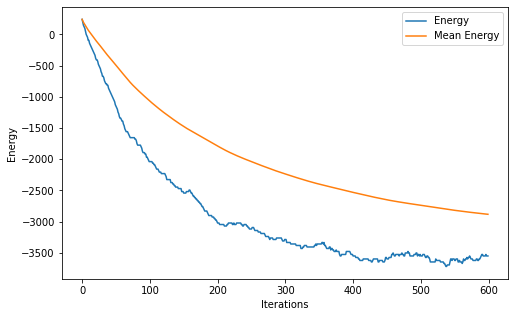

In [39]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(Energy,label="Energy")
ax.plot(mean_Energy,label="Mean Energy")
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.legend()
plt.show()

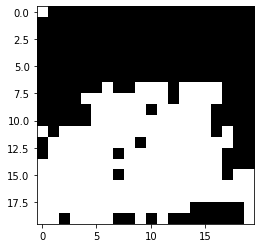

In [40]:
Lattice = grid[0,:,:].compute()
img = plt.imshow(Lattice, interpolation='none', cmap='binary')

### In the future, useful variation, could be to have a dynamic number of parallel simulations depending on the stange or metric of the computation. Another useful variation is to perform more spinflips on each grid and then compute energy.